Step 1: Import library

In [22]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# ==========================
# Data & basic tools
# ==========================
import pandas as pd
import numpy as np

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Statistical analysis
# ==========================
from scipy.stats import (
    ttest_ind, 
    levene, 
    chi2_contingency, 
    skew, 
    kurtosis, 
    pearsonr, 
    f_oneway
)
import statsmodels.api as sm

# ==========================
#  Structural Equation Modeling
# ==========================
from semopy import Model, calc_stats

# ==========================
# Time series modeling
# ==========================
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==========================
# Machine Learning (Random Forest)
# ==========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================
# Deep Learning (LSTM)
# ==========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [27]:
df = pd.read_csv("../../Dataset/household.csv")

In [28]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [29]:

# change date column into datetime 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# merge data by hour (mean)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)  
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 605260 → After merging followed by hour: 10234


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500
...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000


Step 2.3: Prepare some data columns

In [30]:


df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Lag features
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [31]:
df_hour

,date,active_power,temp,feels_like,pressure,humidity,speed,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,28.653167,27.250167,1013.916667,21.083333,3.781167,6,1,224.355000,248.780000,273.720891
25,2022-11-06 15:00:00,297.003333,28.226667,26.947833,1013.016667,21.516667,4.559333,6,1,163.376667,202.663333,277.651724
26,2022-11-06 16:00:00,396.440000,27.816167,26.716833,1013.250000,22.916667,4.938667,6,1,297.003333,198.863333,285.884085
27,2022-11-06 17:00:00,311.295000,25.777500,25.265667,1013.166667,24.566667,4.757667,6,1,396.440000,390.181667,282.597141
28,2022-11-06 18:00:00,443.610000,23.328667,22.383333,1011.133333,25.483333,4.779167,6,1,311.295000,443.036667,282.621030
...,...,...,...,...,...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889,4,0,235.570833,293.395455,241.304597
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322,4,0,329.995556,342.735593,243.407775
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525,4,0,393.211864,396.593220,236.618439
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000,4,0,233.649153,406.398333,235.273231


Step 3. Implement models

3.6 ARIMAX Time Series Model


=== OPTIMIZED ARIMAX GRID SEARCH ===
ARIMAX(0, 0, 0) → AIC=95189.26, MAE=57.3722, RMSE=76.1979
ARIMAX(0, 0, 1) → AIC=95150.18, MAE=60.2730, RMSE=78.7422
ARIMAX(0, 0, 2) → AIC=94742.60, MAE=85.8737, RMSE=110.6863
ARIMAX(0, 1, 0) → AIC=94991.51, MAE=379.4828, RMSE=490.7156
ARIMAX(0, 1, 1) → AIC=91917.85, MAE=820.0033, RMSE=1039.7103
ARIMAX(0, 1, 2) → AIC=91838.41, MAE=943.1962, RMSE=1210.2402
ARIMAX(1, 0, 0) → AIC=94798.41, MAE=74.0831, RMSE=95.3135
ARIMAX(1, 0, 1) → AIC=94392.86, MAE=101.4584, RMSE=132.1754
ARIMAX(1, 0, 2) → AIC=94412.19, MAE=102.5510, RMSE=133.4988
ARIMAX(1, 1, 0) → AIC=93384.37, MAE=892.9479, RMSE=1143.6898
ARIMAX(1, 1, 1) → AIC=91720.76, MAE=1039.3254, RMSE=1331.9114
ARIMAX(1, 1, 2) → AIC=92863.07, MAE=535.0143, RMSE=675.9761
ARIMAX(2, 0, 0) → AIC=94621.02, MAE=81.9135, RMSE=105.7745
ARIMAX(2, 0, 1) → AIC=94786.66, MAE=74.5733, RMSE=96.1636
ARIMAX(2, 0, 2) → AIC=95174.58, MAE=57.4446, RMSE=76.2594
ARIMAX(2, 1, 0) → AIC=92541.04, MAE=967.3055, RMSE=1239.8705
ARIMAX(2

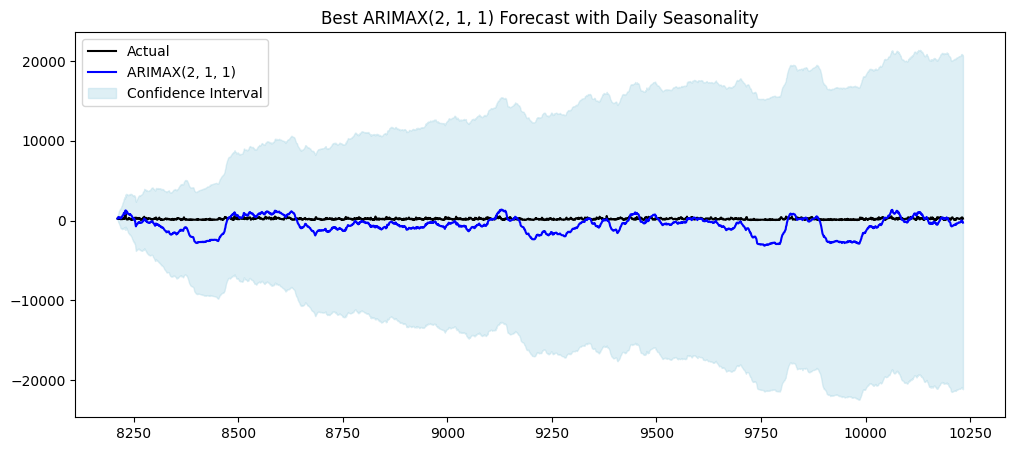

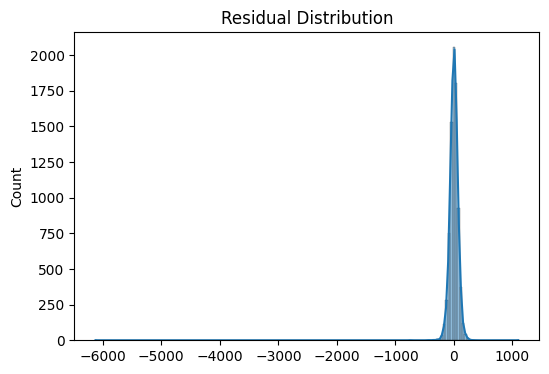

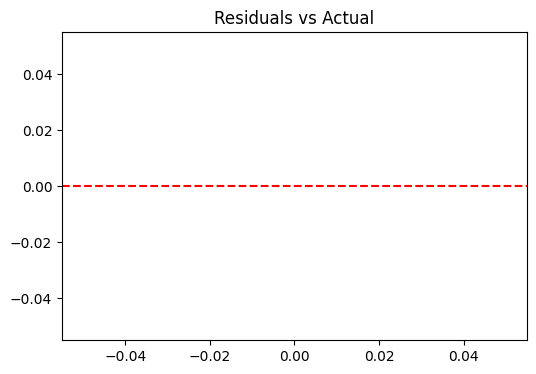

In [32]:
print("\n=== OPTIMIZED ARIMAX GRID SEARCH ===")




# Exogenous variables
exog_vars = [
    v for v in ['temp','humidity','pressure','speed',
                'ap_lag_1h','ap_lag_24h','ap_roll_24h']
    if v in df_hour.columns
]
exog = df_hour[exog_vars]

# Train/test split
split = int(len(df_hour) * 0.8)
y_train = df_hour['active_power'][:split]
y_test  = df_hour['active_power'][split:]
exog_train = exog[:split]
exog_test  = exog[split:]

# Grid search for ARIMA parameters
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
orders = list(product(p, d, q))

results = []

for order in orders:
    try:
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=order,
            seasonal_order=(1, 0, 0, 24),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        res = model.fit(disp=False)
        
        pred = res.get_forecast(steps=len(y_test), exog=exog_test)
        y_pred = pred.predicted_mean
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append((order, res.aic, mae, rmse))
        print(f"ARIMAX{order} → AIC={res.aic:.2f}, MAE={mae:.4f}, RMSE={rmse:.4f}")
    
    except Exception as e:
        print(f"Skip ARIMAX{order} ({e})")
        continue

# Select best model
if len(results) > 0:
    results_sorted = sorted(results, key=lambda x: (x[1], x[2]))
    best_order, best_aic, best_mae, best_rmse = results_sorted[0]
    
    print(f"\nBest ARIMAX{best_order} → AIC={best_aic:.2f}, MAE={best_mae:.4f}, RMSE={best_rmse:.4f}")
    
    best_model = SARIMAX(
        y_train,
        exog=exog_train,
        order=best_order,
        seasonal_order=(1, 0, 0, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    best_res = best_model.fit(disp=False)
    best_pred = best_res.get_forecast(steps=len(y_test), exog=exog_test)
    y_best_pred = best_pred.predicted_mean
    conf_int = best_pred.conf_int()

    # Forecast plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test.index, y_test.values, label='Actual', color='black')
    plt.plot(y_test.index, y_best_pred.values, label=f'ARIMAX{best_order}', color='blue')
    plt.fill_between(
        y_test.index,
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        color='lightblue',
        alpha=0.4,
        label='Confidence Interval'
    )
    plt.legend()
    plt.title(f'Best ARIMAX{best_order} Forecast with Daily Seasonality')
    plt.show()

    # Residual diagnostics
    residuals = best_res.resid

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title("Residual Distribution")
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Actual")
    plt.show()

else:
    print("No ARIMAX model fitted successfully.")
